<a href="https://colab.research.google.com/github/ucheokechukwu/Stock-Prediction-with-Media-Sentiment-Analysis-/blob/main/src/Feature_Engineering_Final_(Sunday).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [458]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [459]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid', context='talk')


import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from helper_functions import stationary_test

import warnings
warnings.filterwarnings('ignore')

In [460]:
prices = pd.read_csv('/content/drive/MyDrive/stock_model/NFLX_fuller.csv',
                        parse_dates=['Date']).set_index('Date')
prices = prices['2015':]

fiscal = pd.read_csv('/content/drive/MyDrive/stock_model/Financial_stats_NFLX.csv',
                 parse_dates = ['Announcement Date'],
                     index_col = ['Announcement Date'])

fiscal = fiscal['2015':]

sentiment = pd.read_csv('/content/drive/MyDrive/stock_model/nflx_full_sentiment.csv',
                        parse_dates = ['date'],
                        index_col = ['date'])
spx = pd.read_csv('/content/drive/MyDrive/stock_model/SPX.csv',
                  parse_dates=['Date']).set_index('Date')['Close/Last']
spx = spx['2015':]

In [461]:
dfs = [prices, fiscal, sentiment, spx]
for df in dfs:
    display(df.head())
    display(df.tail())

,Close,Volume,Open,High,Low
Date,,,,,
2023-06-16,431.96,8753740,446.15,447.51,430.90
2023-06-15,445.27,7099915,444.10,448.65,439.50
2023-06-14,440.86,8413089,434.99,447.33,433.50
2023-06-13,435.73,7820535,430.01,437.27,428.40
2023-06-12,423.97,5967712,418.83,424.70,416.57


,Close,Volume,Open,High,Low
Date,,,,,
2015-01-08,47.78,9622448,47.12,47.84,46.48
2015-01-07,46.74,9832490,47.35,47.42,46.27
2015-01-06,46.50,15984680,47.35,47.64,45.66
2015-01-05,47.31,18107696,49.26,49.26,47.15
2015-01-02,49.85,13322173,49.15,50.33,48.73


,Fiscal Quarter End,Estimated EPS,Actual EPS
Announcement Date,,,
2023-04-18,2023-03-31,2.83,2.88
2023-01-19,2022-12-31,0.47,0.12
2022-10-18,2022-09-30,2.11,3.10
2022-07-19,2022-06-30,2.90,3.20
2022-04-19,2022-03-31,2.92,3.53


,Fiscal Quarter End,Estimated EPS,Actual EPS
Announcement Date,,,
2016-01-19,2015-12-31,0.02,0.07
2015-10-14,2015-09-30,0.07,0.07
2015-07-15,2015-06-30,0.01,0.01
2015-04-15,2015-03-31,0.10,0.11
2015-01-20,2014-12-31,0.06,0.10


,Unnamed: 0,count,normalized
date,,,
2023-06-13,0,4,0.4610
2023-06-12,1,1,0.5570
2023-06-11,2,3,0.7410
2023-06-10,3,1,0.9060
2023-06-09,4,22,0.5721


,Unnamed: 0,count,normalized
date,,,
2018-07-12,915,1,0.973
2018-06-14,916,1,0.995
2018-04-17,917,1,0.995
2018-03-16,918,1,0.991
2018-02-02,919,1,0.996


Date
2023-06-16    4409.59
2023-06-15    4425.84
2023-06-14    4372.59
2023-06-13    4369.01
2023-06-12    4338.93
Name: Close/Last, dtype: float64

Date
2015-01-07    2025.90
2015-01-06    2002.61
2015-01-05    2020.58
2015-01-02    2058.20
2015-01-01    2058.90
Name: Close/Last, dtype: float64

# Exploratory Data Analysis

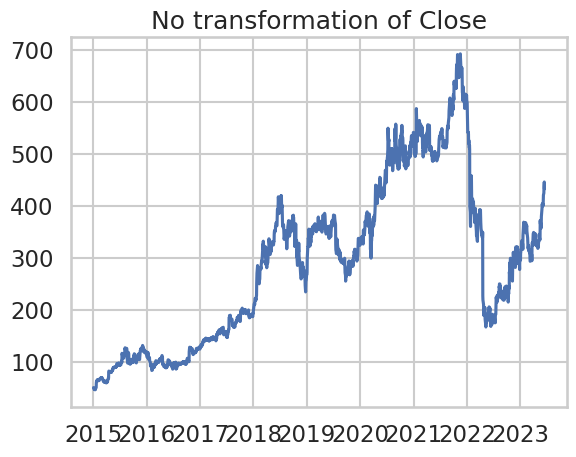

ADF Statistic: -0.787125
p value: 0.822875
Critical value: 
t1%: -3.433
t5%: -2.863
t10%: -2.568
The null hypothesis that the series is NOT stationary cannot be rejected.



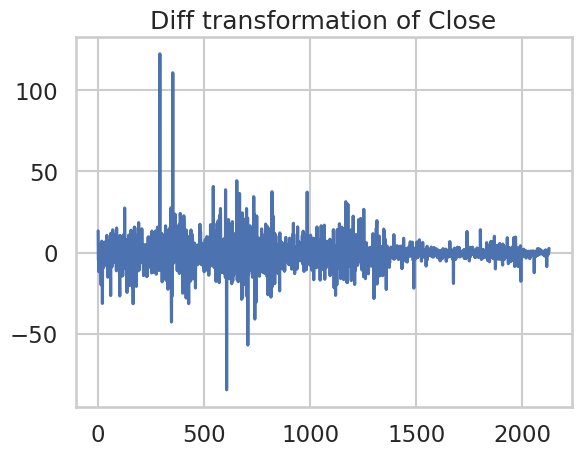

ADF Statistic: -10.126370
p value: 0.000000
Critical value: 
t1%: -3.433
t5%: -2.863
t10%: -2.568
Null hypothesis that the series is not stationary can be REJECTED.


In [462]:
# testing the stationarity of the prices['Close']
import matplotlib.pyplot as plt
stationary_test(prices,'Close')


* So `.diff()` is sufficient to transform prices['Close']. However, I want to represent the rise/fall in relation to the current price.

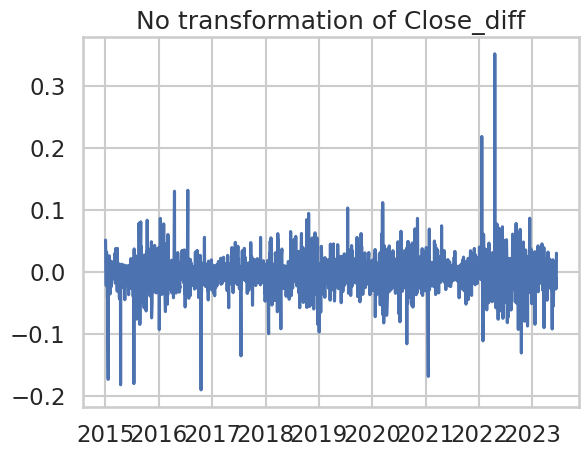

ADF Statistic: -31.360083
p value: 0.000000
Critical value: 
t1%: -3.433
t5%: -2.863
t10%: -2.567
Null hypothesis that the series is not stationary can be REJECTED.


In [463]:
prices['Close_diff'] = prices['Close'].diff()/prices['Close']
stationary_test(prices, 'Close_diff')

In [464]:
prices = prices.drop(columns='Close')
prices['Close'] = prices['Close_diff']
prices = prices.drop(columns='Close_diff')

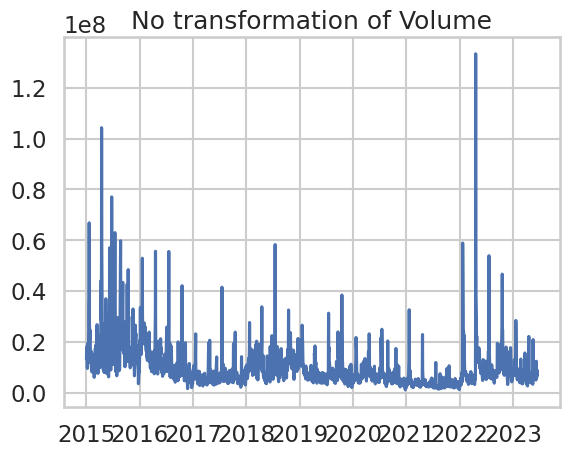

ADF Statistic: -4.344442
p value: 0.000372
Critical value: 
t1%: -3.433
t5%: -2.863
t10%: -2.568
Null hypothesis that the series is not stationary can be REJECTED.


In [465]:
## running the stationarity test on volume and sentiment
stationary_test(prices, 'Volume')

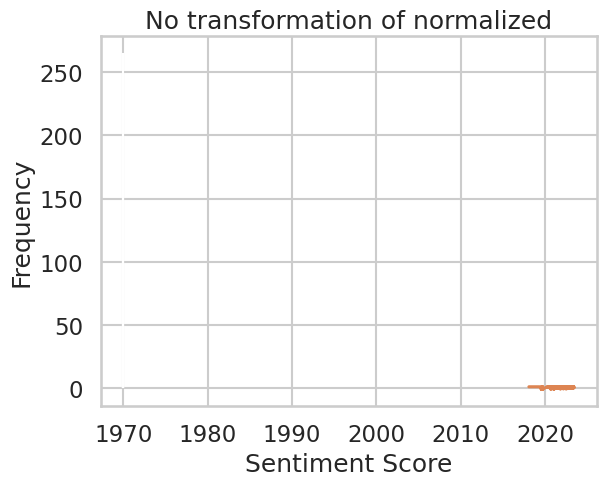

ADF Statistic: -6.262991
p value: 0.000000
Critical value: 
t1%: -3.438
t5%: -2.865
t10%: -2.568
Null hypothesis that the series is not stationary can be REJECTED.


In [466]:
# remove unnecessary index column from sentiment
sentiment = sentiment.drop(columns = ['Unnamed: 0', 'count'])
# view the data
plt.hist(sentiment)
plt.ylabel('Frequency')
plt.xlabel('Sentiment Score')
# running stationary test on sentiment
stationary_test(sentiment, 'normalized')

## Fiscal EDA

- Prove/disprove the Hypothesis that the Actual EPS and Esimate EPS are correlating strongly.

- Check EPS for stationarity and fix it accordingly.

- Merge this value into the main 'prices index' and backfill populate the missing values (i.e there should be an EPS for every record, not just the annoucement dates'

- Use financial data to fill any missing values that cannot be back filled i.e. the time period between April - June

In [467]:
fiscal.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34 entries, 2023-04-18 to 2015-01-20
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Fiscal Quarter End  34 non-null     object 
 1   Estimated EPS       34 non-null     float64
 2   Actual EPS          34 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.1+ KB


In [468]:
fiscal = pd.read_csv('/content/drive/MyDrive/stock_model/Financial_stats_NFLX.csv',
                 parse_dates = ['Announcement Date'],
                     index_col = ['Announcement Date'])

The Null test for correlation between these 2 columns is not rejected. They are correlated strongly.


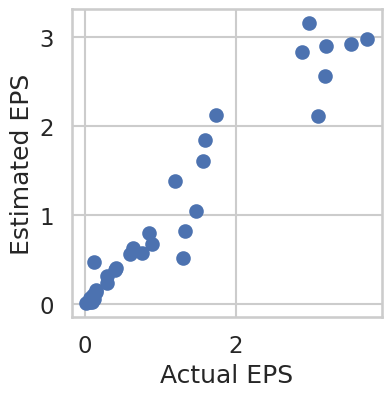

In [469]:
# confirming the correlation between Actual EPS and Estimated EPS
plt.figure(figsize=(4,4))
plt.scatter(fiscal['Actual EPS'], fiscal['Estimated EPS'])
plt.xlabel('Actual EPS')
plt.ylabel('Estimated EPS')
from scipy import stats
res, p = stats.pearsonr(fiscal['Estimated EPS'], fiscal['Actual EPS'])
print ('The Null test for correlation between these 2 columns is',
       'REJECTED' if p>0.05 else 'not rejected. They are correlated',
       'strongly.' if res>0.9 else '.')

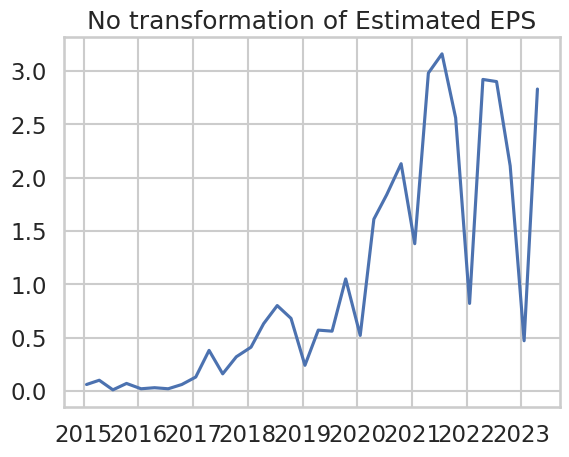

ADF Statistic: -2.038468
p value: 0.269965
Critical value: 
t1%: -3.738
t5%: -2.992
t10%: -2.636
The null hypothesis that the series is NOT stationary cannot be rejected.



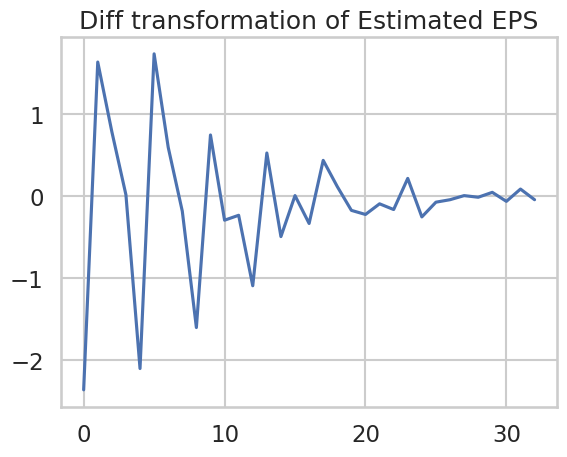

ADF Statistic: -1.852927
p value: 0.354519
Critical value: 
t1%: -3.679
t5%: -2.968
t10%: -2.623
The null hypothesis that the series is NOT stationary cannot be rejected.



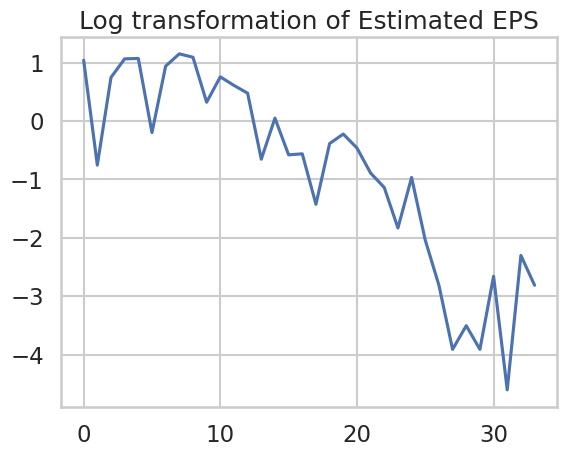

ADF Statistic: 1.077288
p value: 0.995018
Critical value: 
t1%: -3.753
t5%: -2.998
t10%: -2.639
The null hypothesis that the series is NOT stationary cannot be rejected.



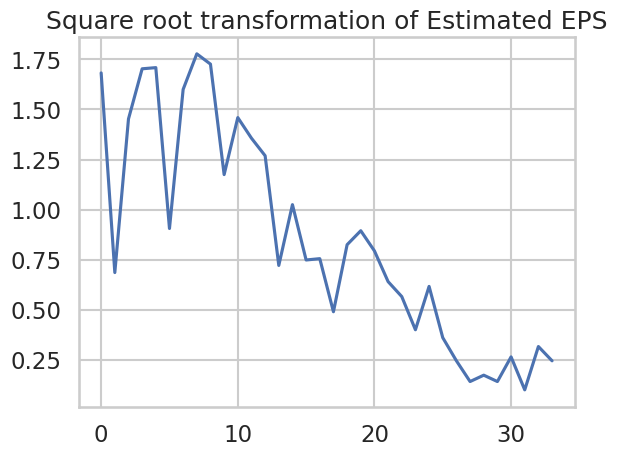

ADF Statistic: -1.072402
p value: 0.725951
Critical value: 
t1%: -3.738
t5%: -2.992
t10%: -2.636
The null hypothesis that the series is NOT stationary cannot be rejected.



In [470]:
# checking Estimated EPS for stationarity
# will assume that this suffices for Actual EPS as well since we can see they are correlating strongly
stationary_test(fiscal, 'Estimated EPS')

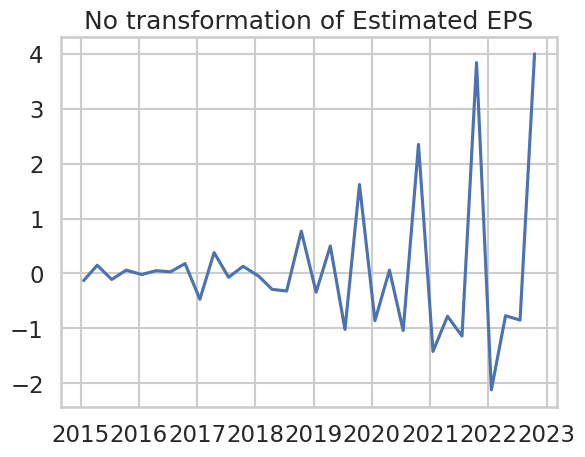

ADF Statistic: -23.519120
p value: 0.000000
Critical value: 
t1%: -3.679
t5%: -2.968
t10%: -2.623
Null hypothesis that the series is not stationary can be REJECTED.


In [471]:
## trying the diff of the diff
fiscal['Estimated EPS'] = fiscal['Estimated EPS'].diff().diff()
stationary_test(fiscal, 'Estimated EPS')

## SPX EDA



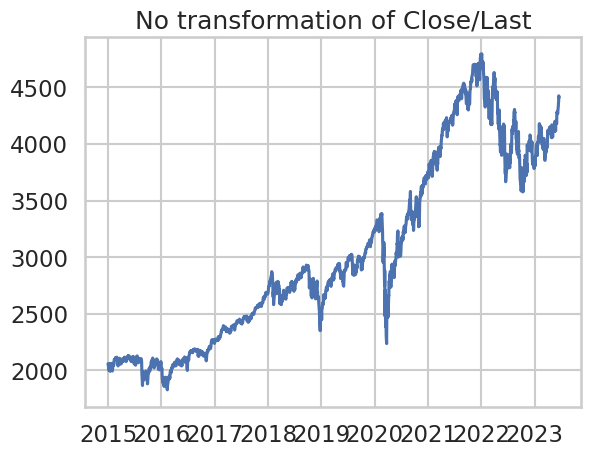

ADF Statistic: -1.173095
p value: 0.685061
Critical value: 
t1%: -3.433
t5%: -2.863
t10%: -2.567
The null hypothesis that the series is NOT stationary cannot be rejected.



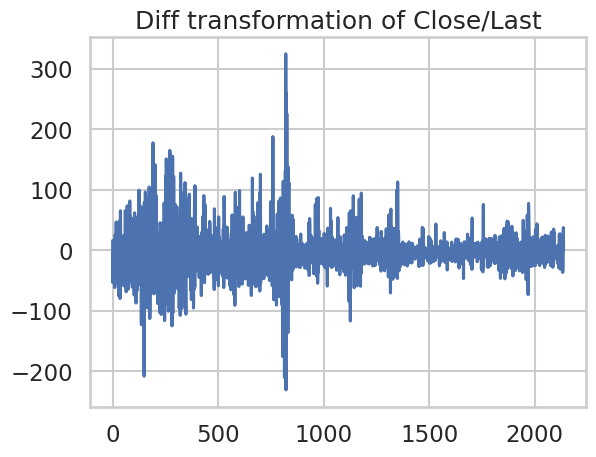

ADF Statistic: -14.441056
p value: 0.000000
Critical value: 
t1%: -3.433
t5%: -2.863
t10%: -2.567
Null hypothesis that the series is not stationary can be REJECTED.


In [472]:
spx = spx.to_frame()
stationary_test(spx, 'Close/Last')

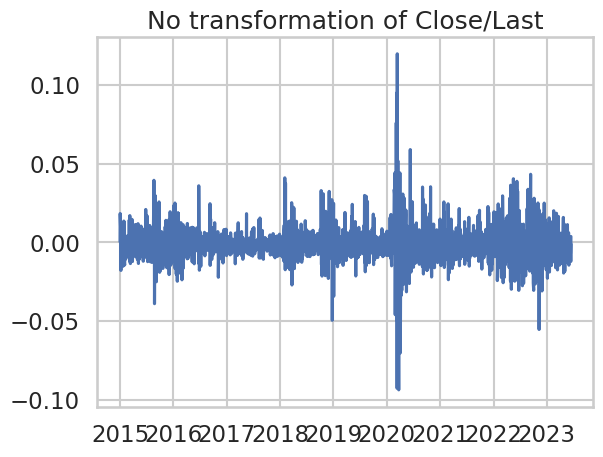

ADF Statistic: -14.434278
p value: 0.000000
Critical value: 
t1%: -3.433
t5%: -2.863
t10%: -2.567
Null hypothesis that the series is not stationary can be REJECTED.


In [473]:
# to be consistent with the NFLX Close transformation, we will also transform this as a delta of its previous price

spx = spx.diff()/spx
stationary_test(spx, 'Close/Last')



## Merging all the features into the main prices list

* Now that I've sorted out the issues of stationary, I can now start merging the features, and doing other statistical tests.

** IMPORTANT** : As this is a **predictor** model, all the features will be time-shifted by 1 Business Day lag. the present-day information can only affect next-day values of y. (The effect of weekends and holidays etc will be considered during further refinement of the model).

In [474]:
fiscal_tmp = fiscal.info() # back up

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34 entries, 2023-04-18 to 2015-01-20
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Fiscal Quarter End  34 non-null     object 
 1   Estimated EPS       32 non-null     float64
 2   Actual EPS          34 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.1+ KB


In [475]:
# merge into the fiscal df first main prices index so that we can populate all the records

fiscal = fiscal.merge(prices, how='outer', left_index=True, right_index=True)
fiscal = fiscal.fillna(method='bfill')
fiscal = fiscal.fillna(method='ffill')
fiscal['Fiscal Quarter End'] = fiscal['Fiscal Quarter End'].fillna('2014-09-30')
fiscal.loc['2023-04-19':,'Fiscal Quarter End'] = '2023-06-30'


# replace the Quarter End date with a relative value
fiscal['Fiscal Quarter End'] = pd.to_datetime(fiscal['Fiscal Quarter End'])
fiscal['Days From Quarter End'] = fiscal.index - fiscal['Fiscal Quarter End']
fiscal['Days From Quarter End'] = fiscal['Days From Quarter End'].dt.days
# keep only necessary columns for now
fiscal = fiscal [['Estimated EPS', 'Actual EPS', 'Days From Quarter End']]
display(fiscal.isna().sum())



Estimated EPS            0
Actual EPS               0
Days From Quarter End    0
dtype: int64

In [476]:
prices.merge(spx, how='left', left_index=True, right_index=True) \
        .merge(fiscal, how='left', left_index=True, right_index=True) \
        .merge(sentiment, how='left', left_index=True, right_index=True)

,Volume,Open,High,Low,Close,Close/Last,Estimated EPS,Actual EPS,Days From Quarter End,normalized
Date,,,,,,,,,,
2023-06-16,8753740,446.15,447.51,430.90,NaN,NaN,4.00,2.88,-14,NaN
2023-06-15,7099915,444.10,448.65,439.50,0.029892,0.003672,4.00,2.88,-15,NaN
2023-06-14,8413089,434.99,447.33,433.50,-0.010003,-0.012178,4.00,2.88,-16,NaN
2023-06-13,7820535,430.01,437.27,428.40,-0.011773,-0.000819,4.00,2.88,-17,0.461
2023-06-12,5967712,418.83,424.70,416.57,-0.027738,-0.006933,4.00,2.88,-18,0.557
...,...,...,...,...,...,...,...,...,...,...
2015-01-08,9622448,47.12,47.84,46.48,0.015488,0.008404,-0.13,0.10,8,NaN
2015-01-07,9832490,47.35,47.42,46.27,-0.022251,-0.017888,-0.13,0.10,7,NaN
2015-01-06,15984680,47.35,47.64,45.66,-0.005161,-0.011630,-0.13,0.10,6,NaN


In [477]:
df = prices.merge(spx, how='left', left_index=True, right_index=True) \
        .merge(fiscal, how='left', left_index=True, right_index=True) \
        .merge(sentiment, how='left', left_index=True, right_index=True)
df.isna().sum()

Volume                      0
Open                        0
High                        0
Low                         0
Close                       1
Close/Last                  1
Estimated EPS               0
Actual EPS                  0
Days From Quarter End       0
normalized               1451
dtype: int64

## Observations so far & Strategy


* So there are a lot of missing values from the **sentiment** table because these records only start from 2018. I will examine its correlation with the price differencing first, and then decide how to handle null values.

* *Actual EPS* is not a good *predictor* of price change as that information comes after the fact. Its influence is small and we have arguably captured that influence with `Days_From_Quarter_End` which responds the market's reaction to quarterly annoucements. I have deliberately decided not to remove the seasonality from that cyclic data for this reason.

* Changes:
1. Estimated EPS will be renamed as EPS. SPX Close/Last will be SPX. Missing values will be replaced by current financial data
2. Open, High, Low will be deleted.
3. normalized will be renamed to Sentiment

In [478]:
df

,Volume,Open,High,Low,Close,Close/Last,Estimated EPS,Actual EPS,Days From Quarter End,normalized
Date,,,,,,,,,,
2023-06-16,8753740,446.15,447.51,430.90,NaN,NaN,4.00,2.88,-14,NaN
2023-06-15,7099915,444.10,448.65,439.50,0.029892,0.003672,4.00,2.88,-15,NaN
2023-06-14,8413089,434.99,447.33,433.50,-0.010003,-0.012178,4.00,2.88,-16,NaN
2023-06-13,7820535,430.01,437.27,428.40,-0.011773,-0.000819,4.00,2.88,-17,0.461
2023-06-12,5967712,418.83,424.70,416.57,-0.027738,-0.006933,4.00,2.88,-18,0.557
...,...,...,...,...,...,...,...,...,...,...
2015-01-08,9622448,47.12,47.84,46.48,0.015488,0.008404,-0.13,0.10,8,NaN
2015-01-07,9832490,47.35,47.42,46.27,-0.022251,-0.017888,-0.13,0.10,7,NaN
2015-01-06,15984680,47.35,47.64,45.66,-0.005161,-0.011630,-0.13,0.10,6,NaN


In [479]:
df.rename(columns={'Estimated EPS': 'EPS',
                   'normalized': 'Sentiment',
                   'Close/Last': 'SPX'}, inplace=True)

df.drop(columns=['High', 'Low', 'Open', 'Actual EPS'], inplace=True)
df

,Volume,Close,SPX,EPS,Days From Quarter End,Sentiment
Date,,,,,,
2023-06-16,8753740,NaN,NaN,4.00,-14,NaN
2023-06-15,7099915,0.029892,0.003672,4.00,-15,NaN
2023-06-14,8413089,-0.010003,-0.012178,4.00,-16,NaN
2023-06-13,7820535,-0.011773,-0.000819,4.00,-17,0.461
2023-06-12,5967712,-0.027738,-0.006933,4.00,-18,0.557
...,...,...,...,...,...,...
2015-01-08,9622448,0.015488,0.008404,-0.13,8,NaN
2015-01-07,9832490,-0.022251,-0.017888,-0.13,7,NaN
2015-01-06,15984680,-0.005161,-0.011630,-0.13,6,NaN


## Sentiment Analysis

count    678.000000
mean       0.555670
std        0.326322
min       -0.973000
25%        0.408150
50%        0.567600
75%        0.749475
max        1.000000
Name: Sentiment, dtype: float64

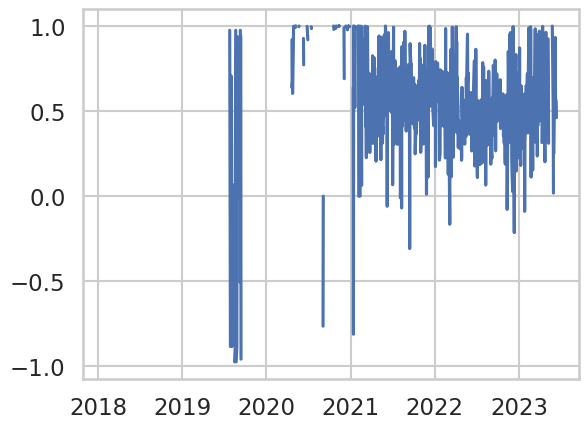

In [480]:
# visualizing Sentiment
plt.plot(df['Sentiment'])
df['Sentiment'].describe()

* Note that sentiment analysis records start from 2018 so it would be wiser to only test those records against the 'Close' target.

In [481]:
# creating a dataframe with just these 2 parameters

sentiment_close = sentiment.merge(df['Close'].shift(1,freq='B').dropna(), left_index=True, right_index=True).dropna()
sentiment_close.rename(columns={'normalized': 'sentiment'}, inplace=True)

The Null test for correlation between these 2 columns is REJECTED .


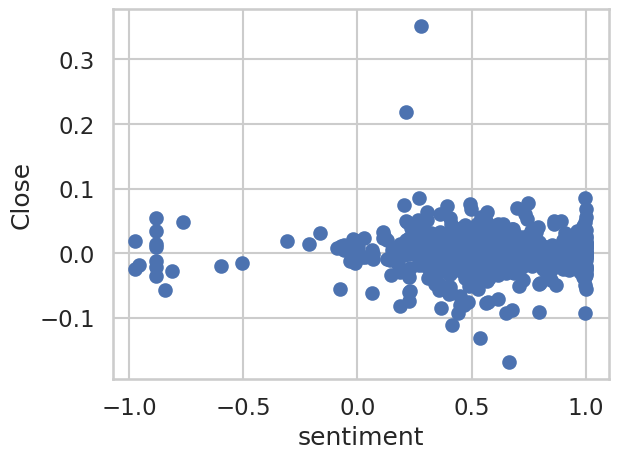

In [482]:
# checking correlation with df['Close']
plt.scatter(sentiment_close['sentiment'], sentiment_close['Close'])
plt.xlabel('sentiment')
plt.ylabel('Close')

from scipy import stats
res, p = stats.pearsonr(sentiment_close['sentiment'], sentiment_close['Close'])
print ('The Null test for correlation between these 2 columns is',
       'REJECTED' if p>0.05 else 'not rejected. They are correlated',
       'strongly.' if res>0.9 else '.')

(array([ 16.,   3.,   3.,   8.,  34.,  46., 143., 265., 195., 207.]),
 array([-0.973 , -0.7757, -0.5784, -0.3811, -0.1838,  0.0135,  0.2108,
         0.4081,  0.6054,  0.8027,  1.    ]),
 <BarContainer object of 10 artists>)

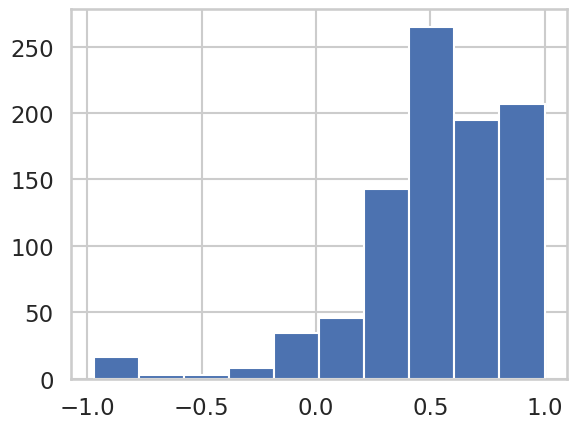

In [483]:
plt.hist(sentiment)

Strategy: for the years after Sentiment data was collected, it will be front-filled i.e. we assume the sentiment did not change during those 'gap' periods.

For the years before Sentiment data was collected, it will be filled with the mode of the distribution.

In [484]:
df['Sentiment']['2018':] = df['Sentiment']['2018':].fillna(method='bfill') # fill with the last sentiment i.e. assume sentiment did not change

df['Sentiment'].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 2129 entries, 2023-06-16 to 2015-01-02
Series name: Sentiment
Non-Null Count  Dtype  
--------------  -----  
1352 non-null   float64
dtypes: float64(1)
memory usage: 97.8 KB


(array([151.,   6.,   1.,   2.,  22.,  30., 114., 227., 940., 636.]),
 array([-0.973 , -0.7757, -0.5784, -0.3811, -0.1838,  0.0135,  0.2108,
         0.4081,  0.6054,  0.8027,  1.    ]),
 <BarContainer object of 10 artists>)

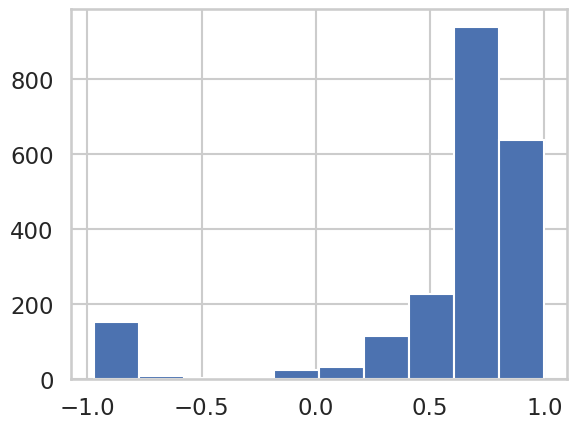

In [485]:
df['Sentiment'] = df['Sentiment'].fillna(df['Sentiment'].median())
plt.hist(df['Sentiment'])

Text(0, 0.5, 'Close')

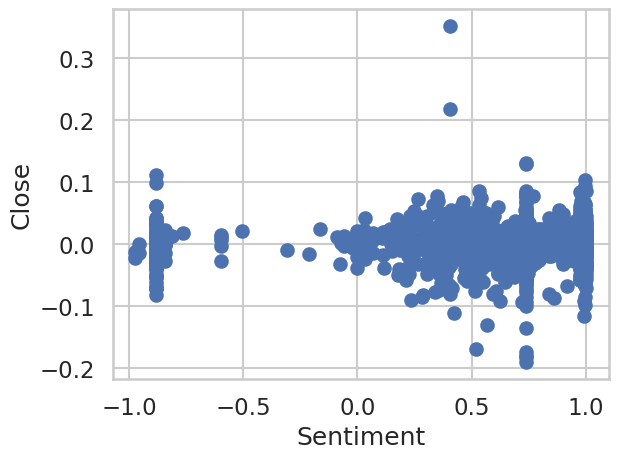

In [486]:
plt.scatter(df['Sentiment'], df['Close'])
plt.xlabel('Sentiment')
plt.ylabel('Close')

In [487]:
# checking again for missing values
display(df.isna().sum())
df.info()

Volume                   0
Close                    1
SPX                      1
EPS                      0
Days From Quarter End    0
Sentiment                0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2129 entries, 2023-06-16 to 2015-01-02
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Volume                 2129 non-null   int64  
 1   Close                  2128 non-null   float64
 2   SPX                    2128 non-null   float64
 3   EPS                    2129 non-null   float64
 4   Days From Quarter End  2129 non-null   int64  
 5   Sentiment              2129 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 181.0 KB


* the missing values are from 'Close' (SPX and NFLX), the result of differencing the column, and  will be dropped

In [488]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2128 entries, 2023-06-15 to 2015-01-02
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Volume                 2128 non-null   int64  
 1   Close                  2128 non-null   float64
 2   SPX                    2128 non-null   float64
 3   EPS                    2128 non-null   float64
 4   Days From Quarter End  2128 non-null   int64  
 5   Sentiment              2128 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 116.4 KB


In [527]:
df.to_csv('/content/drive/MyDrive/stock_model/completed_dataframe.csv')

# Feature Analysis

Model building. I will be using visualizations and statistical tests to perform feature selection for the model.

In [ ]:
# from helper_functions import plot_dual_line_graph

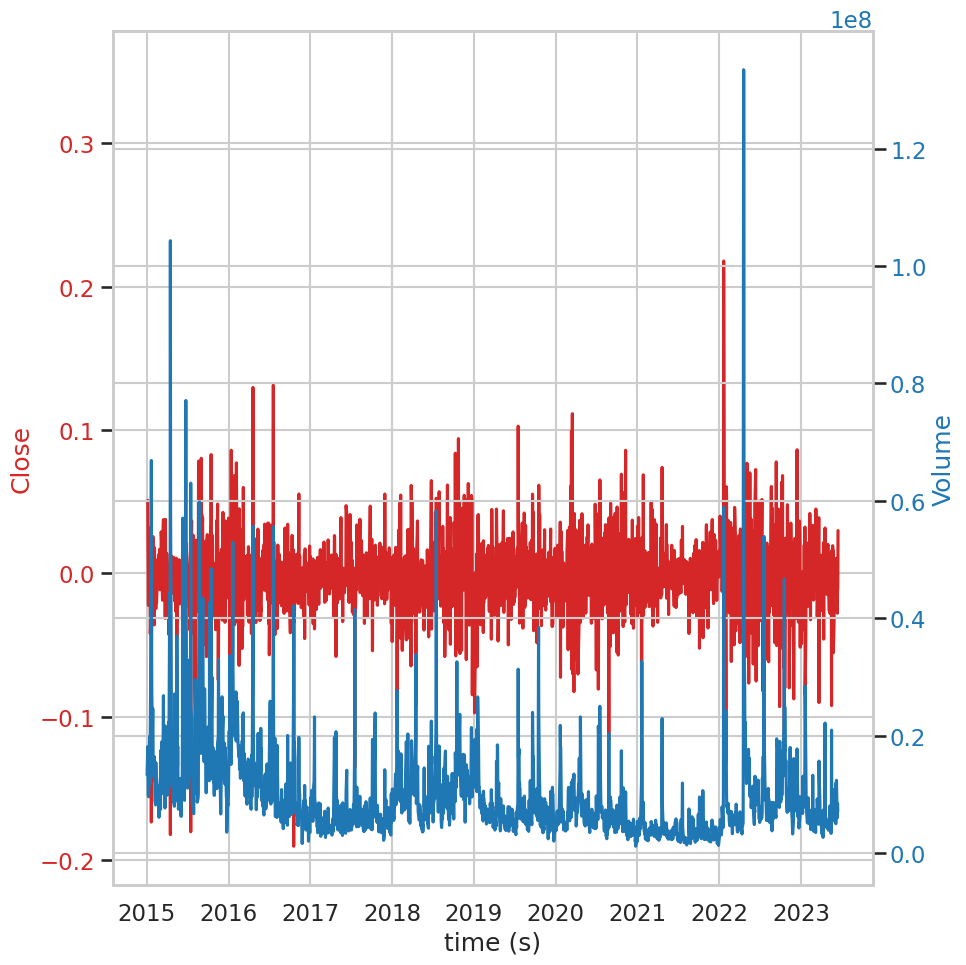

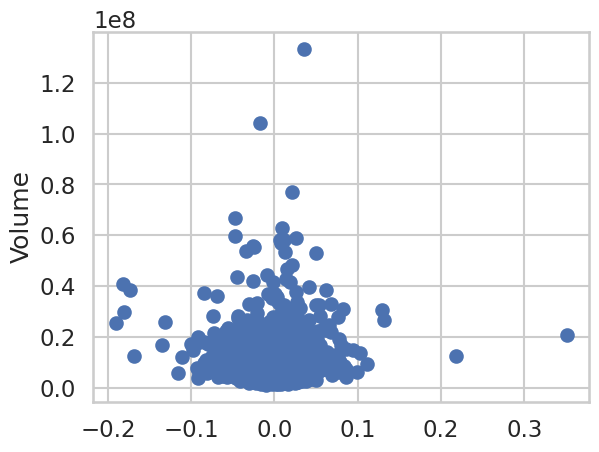

The Null test for correlation between Volume and "Close" columns is REJECTED .


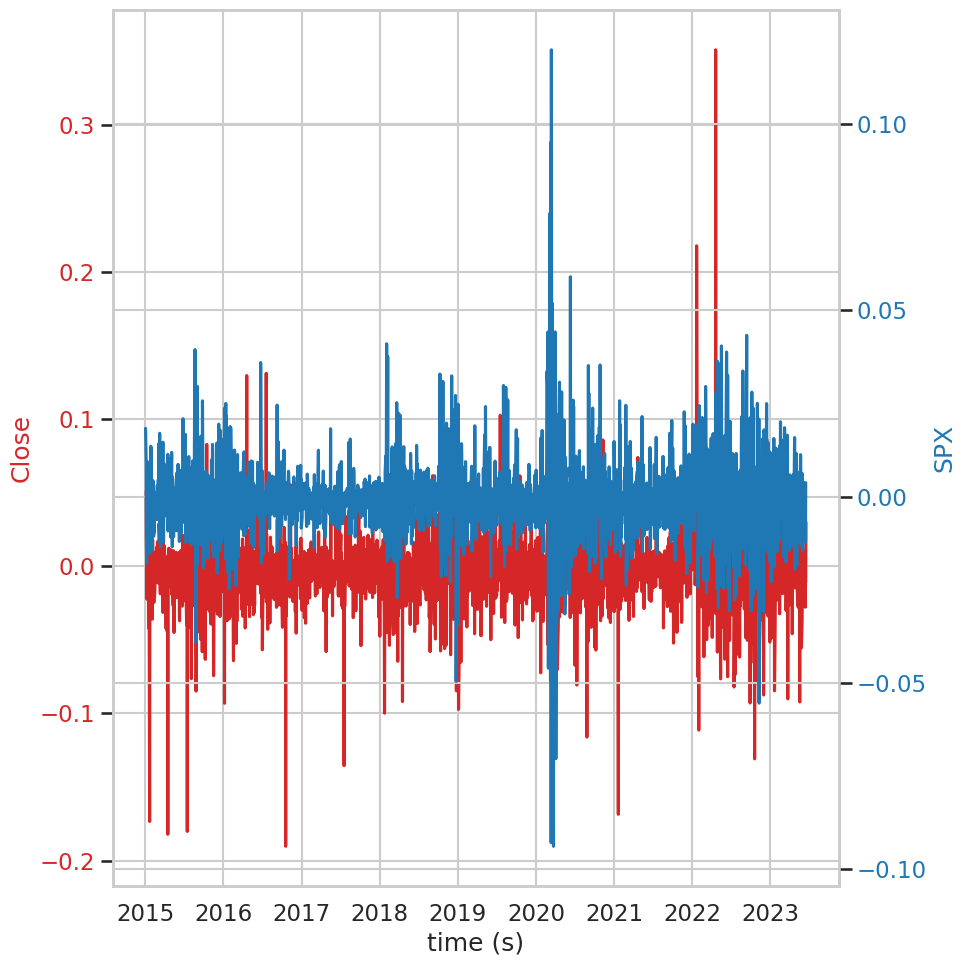

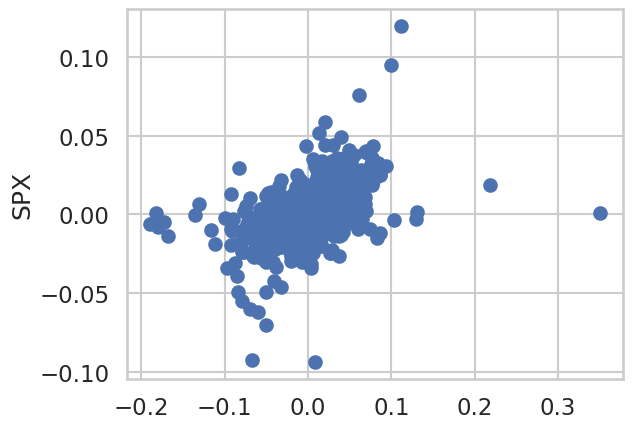

The Null test for correlation between SPX and "Close" columns is not rejected. They are correlated .


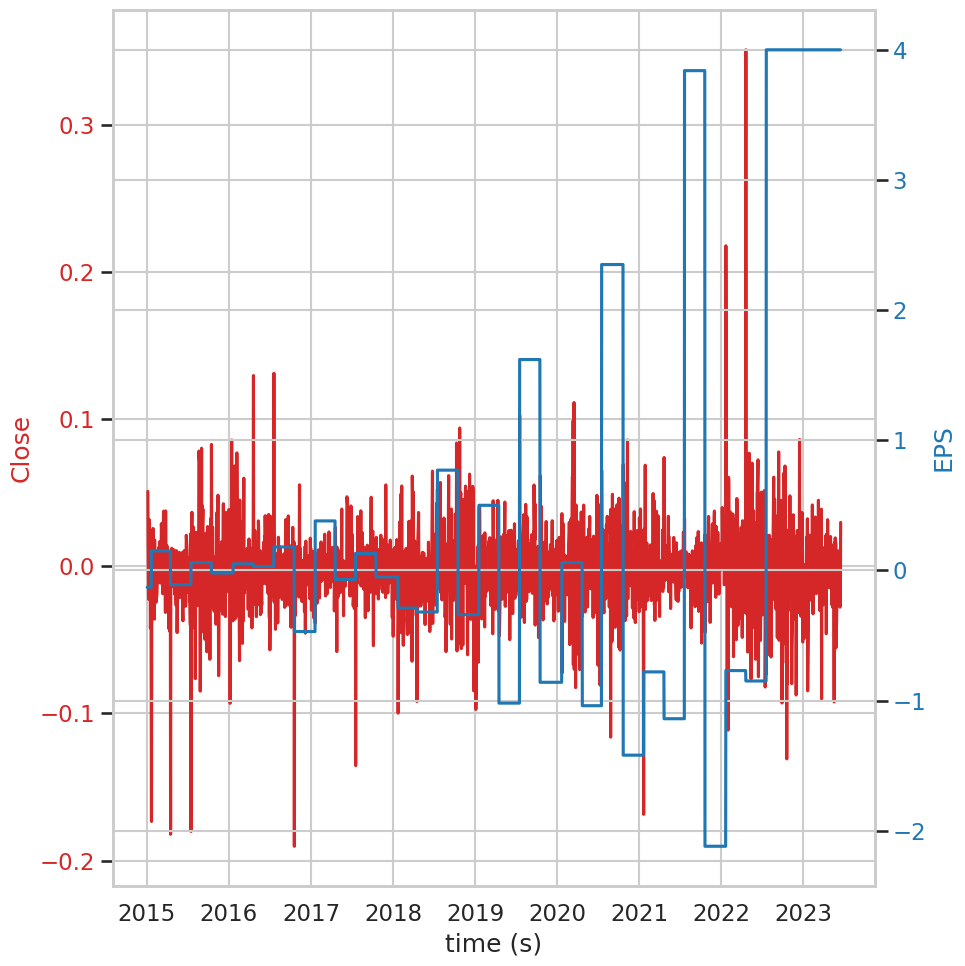

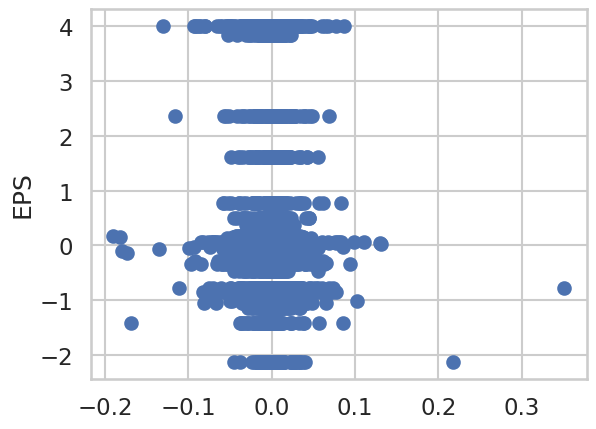

The Null test for correlation between EPS and "Close" columns is REJECTED .


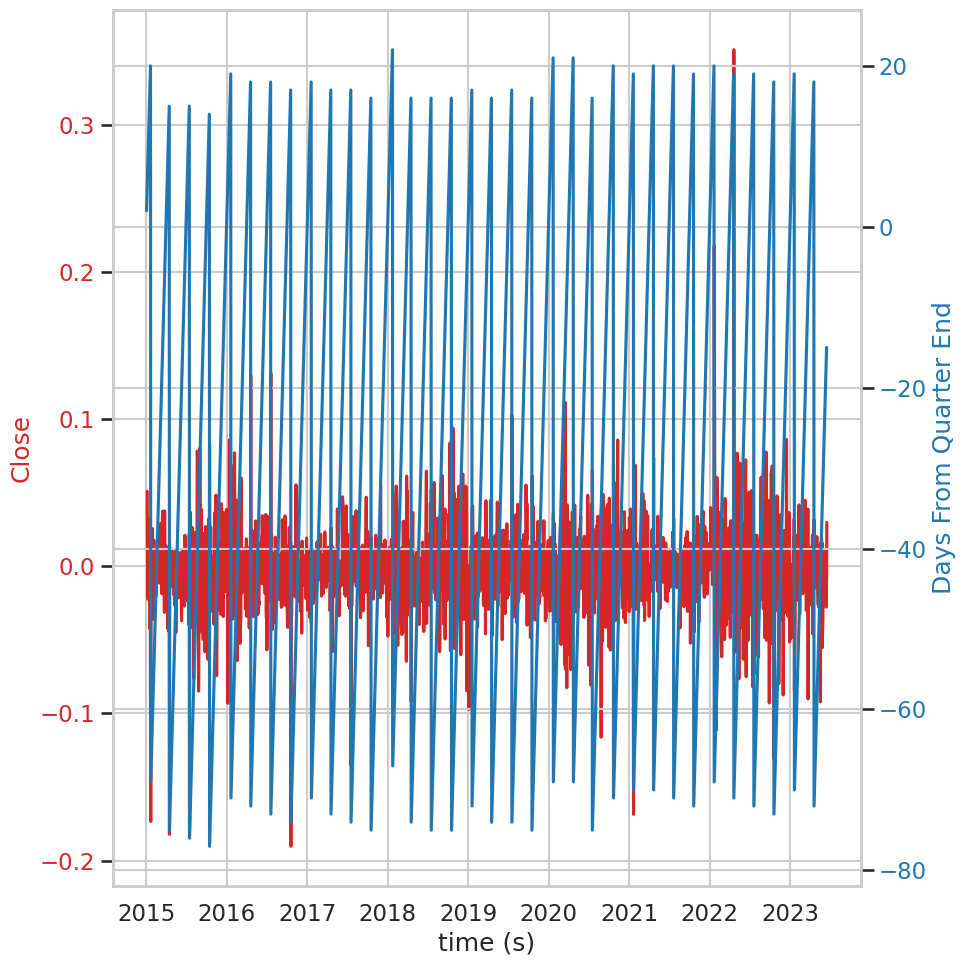

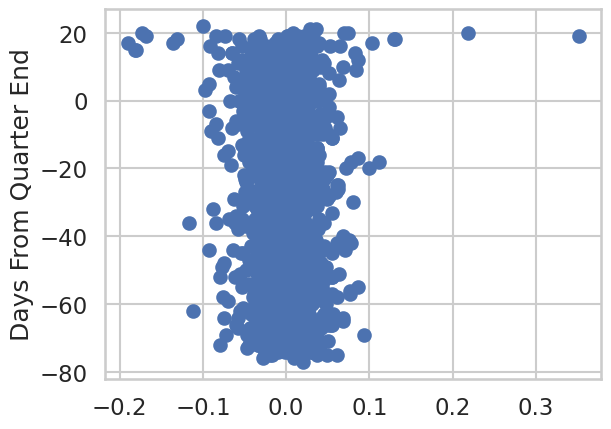

The Null test for correlation between Days From Quarter End and "Close" columns is REJECTED .


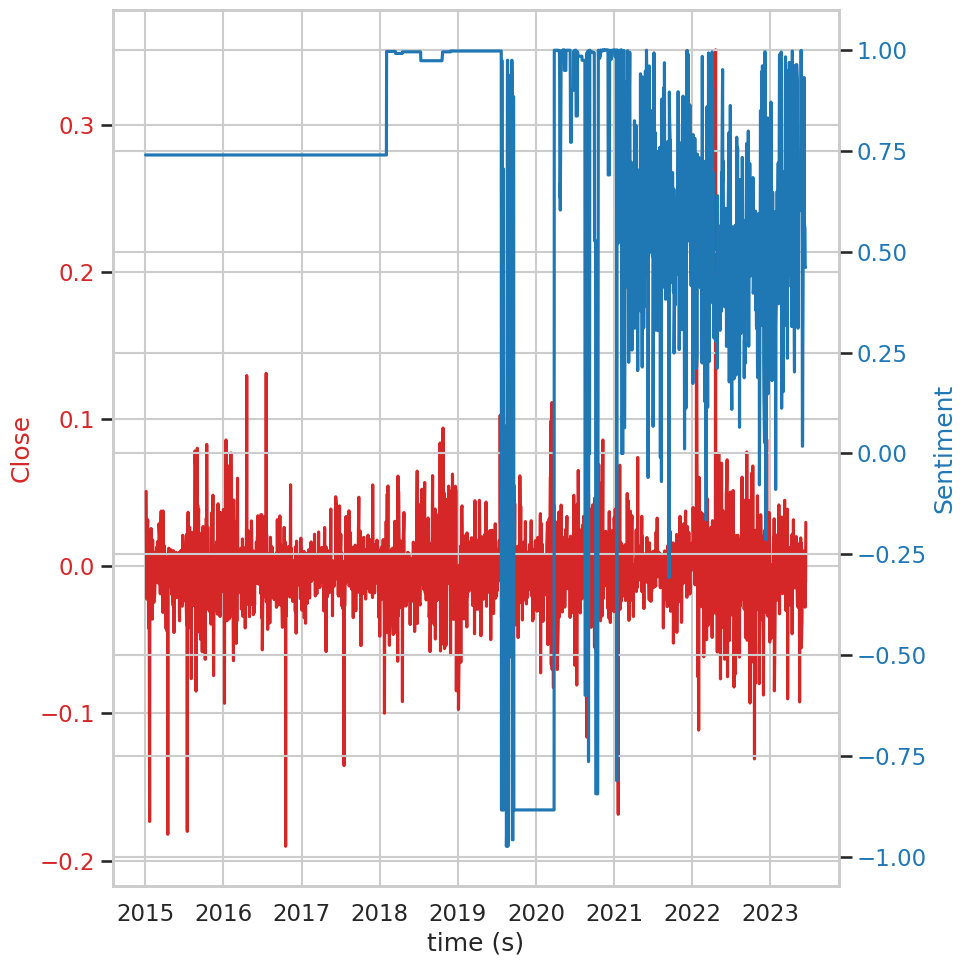

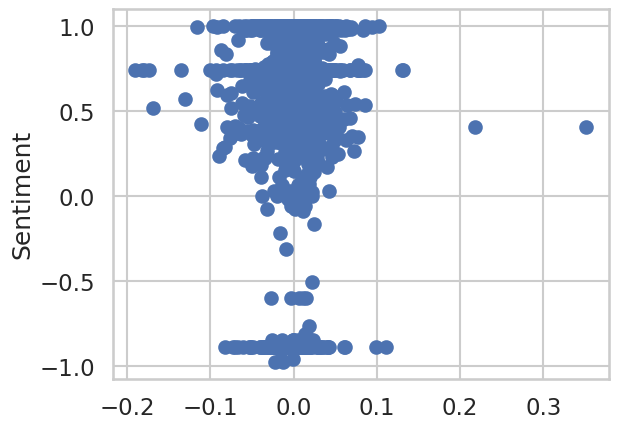

The Null test for correlation between Sentiment and "Close" columns is REJECTED .


In [491]:
for col in df.columns:
    if col == 'Close':
        continue

    plot_dual_line_graph(df['Close'].shift(1, freq='B').dropna(), df[col])
    plt.show()
    plt.scatter(df['Close'], df[col])
    plt.ylabel(col)
    plt.show()
    res, p = stats.pearsonr(df[col], df['Close'])
    print (f'The Null test for correlation between {col} and "Close" columns is',
       'REJECTED' if p>0.05 else 'not rejected. They are correlated',
       'strongly.' if res>0.9 else '.')


                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.584
Date:                Sun, 18 Jun 2023   Prob (F-statistic):             0.0244
Time:                        19:55:12   Log-Likelihood:                 4406.3
No. Observations:                2050   AIC:                            -8801.
Df Residuals:                    2044   BIC:                            -8767.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

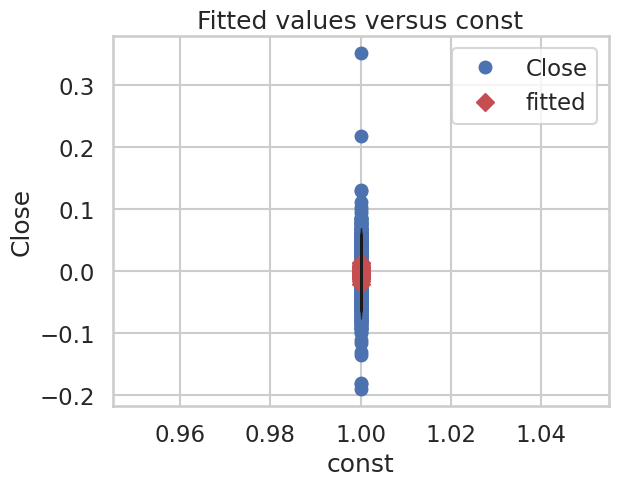

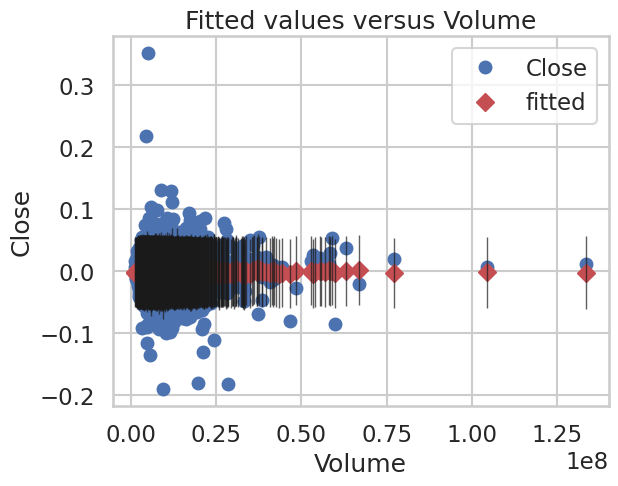

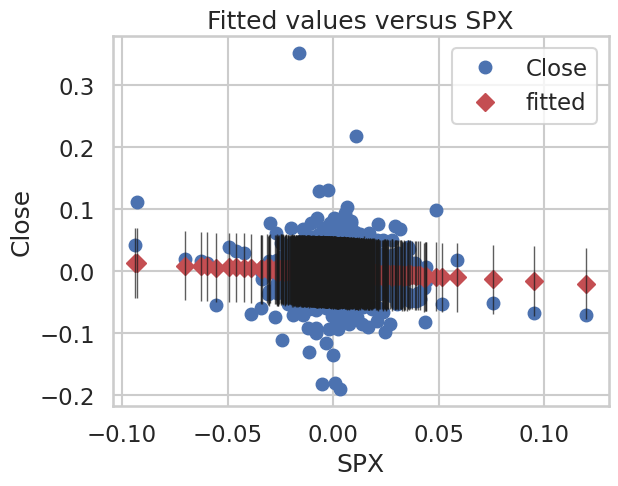

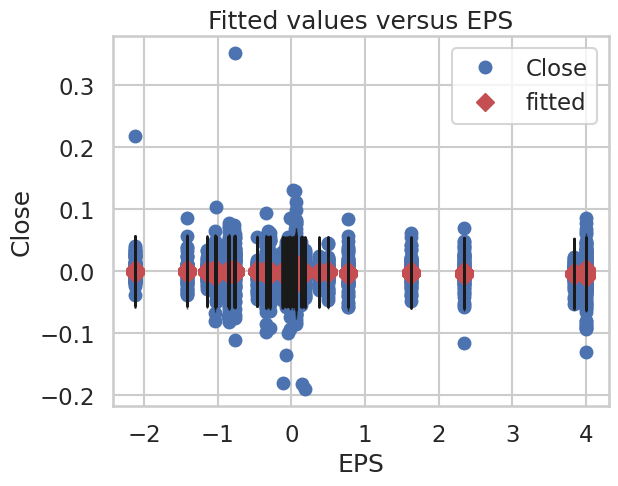

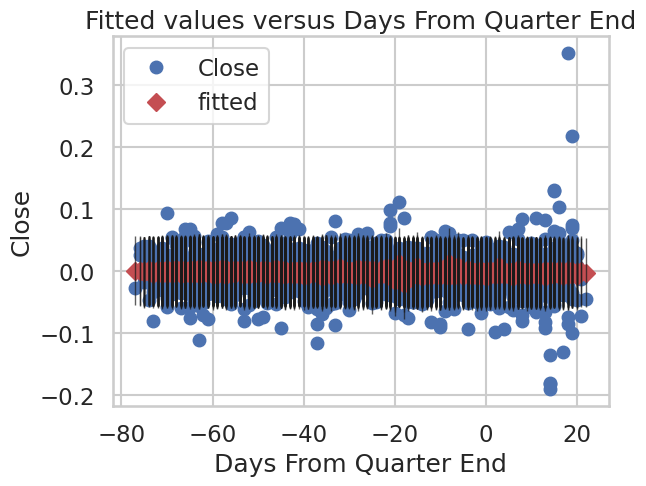

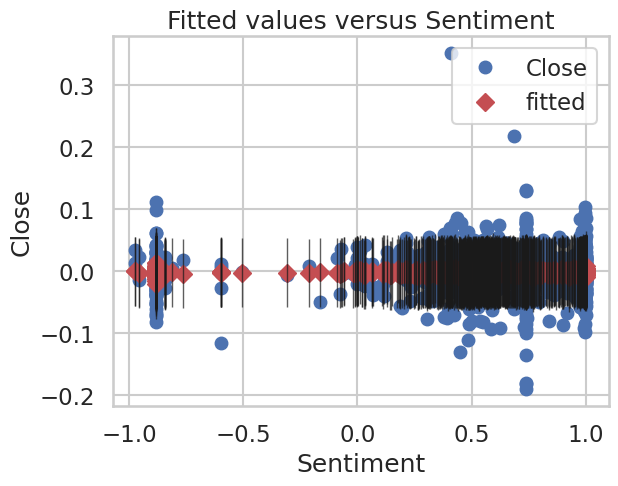

In [492]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler()
X = df.drop(columns='Close')
# time shifting y
y = df['Close'].shift(-1,freq='B').dropna()
# merging the 2 back together
df_xy = X.merge(y, left_index=True, right_index=True).dropna()
y = df_xy['Close']
X = df_xy.drop(columns='Close')


X_scaled = scaler_x.fit_transform(X)

X_scaled = pd.DataFrame(X, columns=(df.drop(columns='Close').columns))
X_scaled = sm.add_constant(X_scaled)

# scaler_y = MinMaxScaler()
# y_scaled = scaler_y.fit_transform(df['Close'].values.reshape(-1,1))


model = sm.OLS(y, X_scaled)
results = model.fit()
print(results.summary())



for col in range(6):
    fig, ax = plt.subplots()
    fig = sm.graphics.plot_fit(results, col, ax=ax)
    plt.show()


**Note**: None of the features are statistically significant but EPS comes close. We wil repeat this test after discretizing the *Close* parameter.

# Feature Engineering (Output)

## 1. Discretization of Price Movement

The exact stock price value on its own doesn't give us any information to make a financial decision. Also a mse of 0.02 is irrelevant if we're constantly predicting that same error. For this algorithm to be useful, it should be able to predict how the price is *moving*, which will then enable us to determine a strategy (buy low, sell high).


The **Close** value will be converted into a Price movement value with 5 labels:

-2 : (Strong Bear 🐻)🐮

-1 : (Bear 🧸)

0 : Hold ⏱️ - price variation too low to be worth speculating

1 : (Bull 🐄)

2: (Strong Bull 🐂)

p is 1.0. 
The null hypothesis can be accepted. The distribution is likely normal.


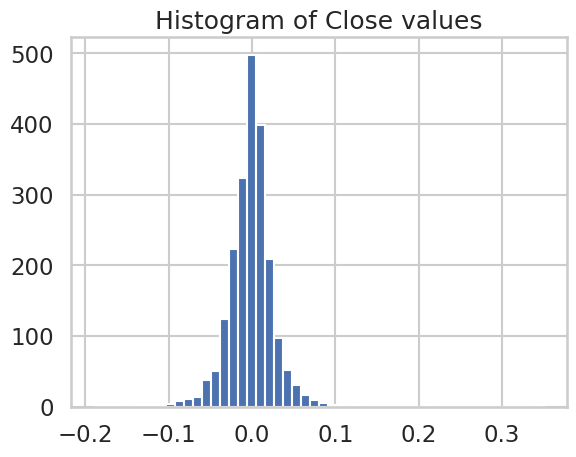

In [493]:
plt.hist(df['Close'], bins=50)
plt.title ('Histogram of Close values')
from scipy import stats
k2, p = stats.shapiro(np.log(df['Close']))
print(f"p is {p}. \nThe null hypothesis can be",
      "rejected. The distribution is not likely normal." \
      if p<0.05 else "accepted. The distribution is likely normal.")

Using qcut will balance the data and give us equal values
Which will be advisable when classifying the data.
However using the statistically relevant boundaries will be more helpful.
We will test both

Text(0.5, 1.0, 'Discretization of Close with Qcut')

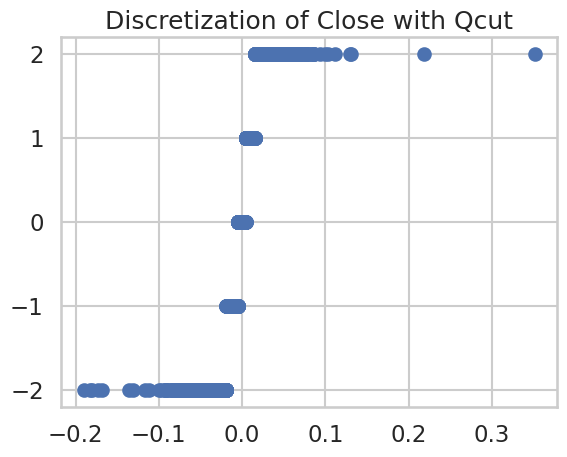

In [494]:
df['MovementQ'] = pd.qcut(df['Close'], q=5, labels = [-2, -1, 0, 1, 2], retbins=True)
plt.scatter(df['Close'], df['MovementQ'])
plt.title('Discretization of Close with Qcut')

In [495]:
df['MovementQ'].value_counts()

-2    426
0     426
2     426
-1    425
1     425
Name: MovementQ, dtype: int64

 0    508
-1    503
 1    496
 2    314
-2    307
Name: MovementH, dtype: int64

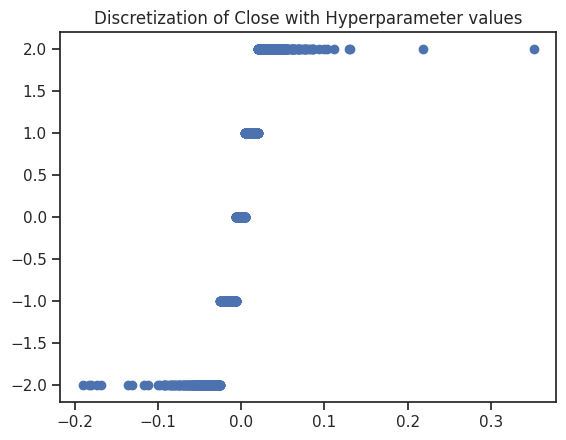

In [713]:
def finstat_cut(df):
    # bins = [-0.10, -0.05, 0, 0.05, 0.10]
    bins = [-0.025, -0.006, -0.000, 0.005, 0.02] # hyperparameter values (see below)

    if df < bins[0]:
        bin = -2
    elif df< bins[1]:
        bin = -1
    elif df>bins[4]:
        bin = 2
    elif df>bins[3]:
        bin = 1
    else:
        bin = 0
    return bin

df['MovementH'] = df['Close'].apply(lambda x: finstat_cut(x))
plt.scatter(df['Close'], df['MovementH'])
# plt.title('Discretization of Close with Financial margins')
plt.title('Discretization of Close with Hyperparameter values')

df['MovementH'].value_counts()

* Going with MovementQ. It is more customized to the price movements of the NFLX stock.

In [497]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2128 entries, 2023-06-15 to 2015-01-02
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Volume                 2128 non-null   int64   
 1   Close                  2128 non-null   float64 
 2   SPX                    2128 non-null   float64 
 3   EPS                    2128 non-null   float64 
 4   Days From Quarter End  2128 non-null   int64   
 5   Sentiment              2128 non-null   float64 
 6   MovementQ              2128 non-null   category
 7   MovementF              2128 non-null   int64   
dtypes: category(1), float64(4), int64(3)
memory usage: 199.8 KB


## 2. Time Shifting the Move
This is a predictor model. All the observations are made with at least one day lag.

In [714]:
data = df.copy()

In [715]:
# y = data['MovementF'].shift(1) # time shifting the target value by one day
y = data['MovementH'].shift(1) # time shifting the target value by one day
# all the features need to lag the PREDICTOR model
# for this to be realistic
data = data.merge(y, left_index=True, right_index=True, how='outer')
data.head()

,Volume,Close,SPX,EPS,Days From Quarter End,Sentiment,MovementQ,MovementF,MovementH_x,MovementH_y
Date,,,,,,,,,,
2023-06-15,7099915,0.029892,0.003672,4.0,-15,0.4610,2,2,2,NaN
2023-06-14,8413089,-0.010003,-0.012178,4.0,-16,0.4610,-1,-1,-1,2.0
2023-06-13,7820535,-0.011773,-0.000819,4.0,-17,0.4610,-1,-1,-1,-1.0
2023-06-12,5967712,-0.027738,-0.006933,4.0,-18,0.5570,-2,-2,-2,-1.0
2023-06-09,12372830,-0.009404,-0.009321,4.0,-21,0.5721,-1,-1,-1,-2.0


In [509]:
data = data.rename(columns={'MovementF_y': 'MovementF'})
data.drop(columns=['MovementF_x'], inplace=True)
data

,Volume,Close,SPX,EPS,Days From Quarter End,Sentiment,MovementQ,MovementF
Date,,,,,,,,
2023-06-15,7099915,0.029892,0.003672,4.00,-15,0.4610,2,NaN
2023-06-14,8413089,-0.010003,-0.012178,4.00,-16,0.4610,-1,0.0
2023-06-13,7820535,-0.011773,-0.000819,4.00,-17,0.4610,-1,0.0
2023-06-12,5967712,-0.027738,-0.006933,4.00,-18,0.5570,-2,0.0
2023-06-09,12372830,-0.009404,-0.009321,4.00,-21,0.5721,-1,0.0
...,...,...,...,...,...,...,...,...
2015-01-08,9622448,0.015488,0.008404,-0.13,8,0.7395,1,0.0
2015-01-07,9832490,-0.022251,-0.017888,-0.13,7,0.7395,-2,0.0
2015-01-06,15984680,-0.005161,-0.011630,-0.13,6,0.7395,-1,0.0


In [501]:
# the new missing value is the result of time shift. and will be dropped.
data = data.dropna()

In [720]:
# after hypertuning the bins
data = data.drop(columns=['MovementH_x'])
data = data.rename(columns={'MovementH_y':'MovementH'})
data.head(2)

,Volume,Close,SPX,EPS,Days From Quarter End,Sentiment,MovementQ,MovementF,MovementH
Date,,,,,,,,,
2023-06-15,7099915,0.029892,0.003672,4.0,-15,0.461,2,2,NaN
2023-06-14,8413089,-0.010003,-0.012178,4.0,-16,0.461,-1,-1,2.0


## Statistics and Visualizations
* Now that this is now a classification problem, we will perform categorical-numerical analysis on the existing features one final time before we make a decision about rejecting or keeping the values.

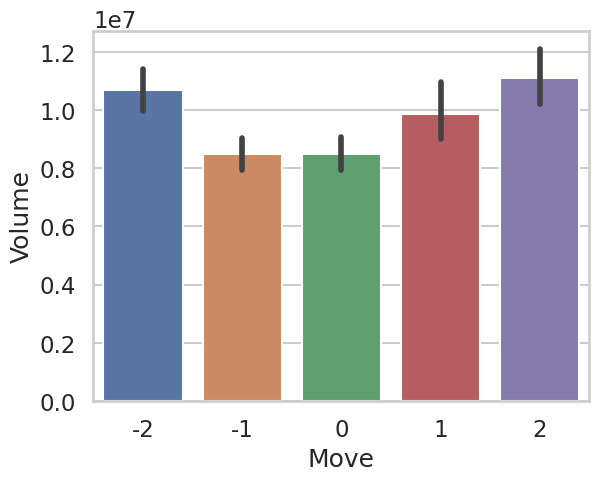

2.274417601871376e-07

Volume and 'Move' are possibly correlated.


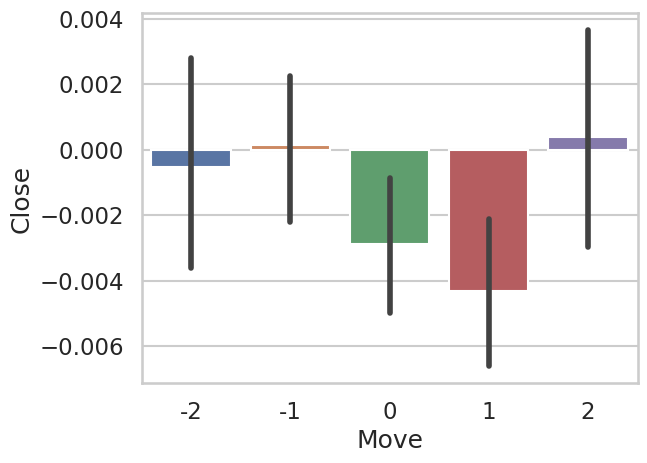

0.06485494095481818

Close and 'Move' are possibly not correlated.


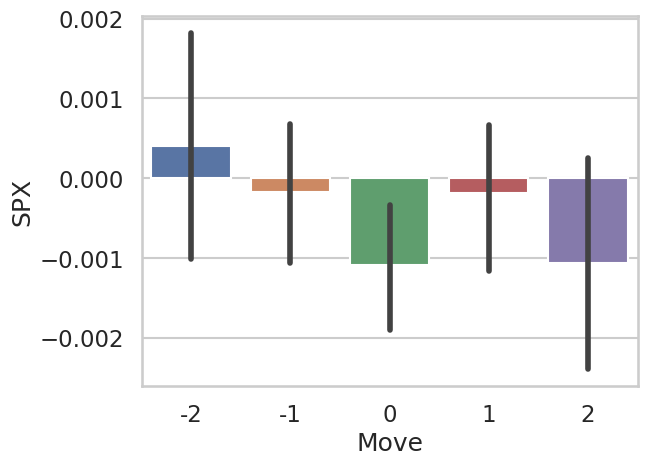

0.2831858038495862

SPX and 'Move' are possibly not correlated.


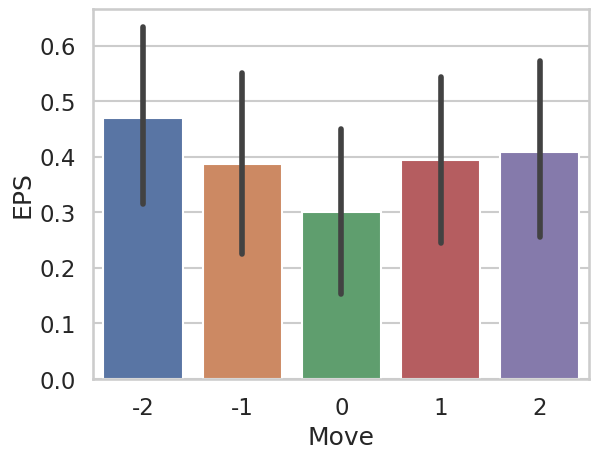

0.670860372837156

EPS and 'Move' are possibly not correlated.


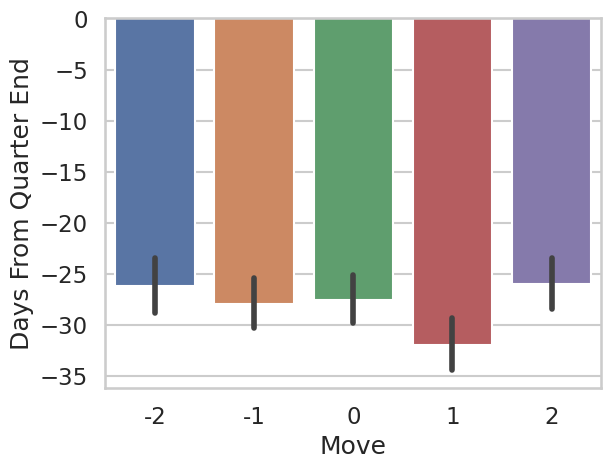

0.007268167933371874

Days From Quarter End and 'Move' are possibly correlated.


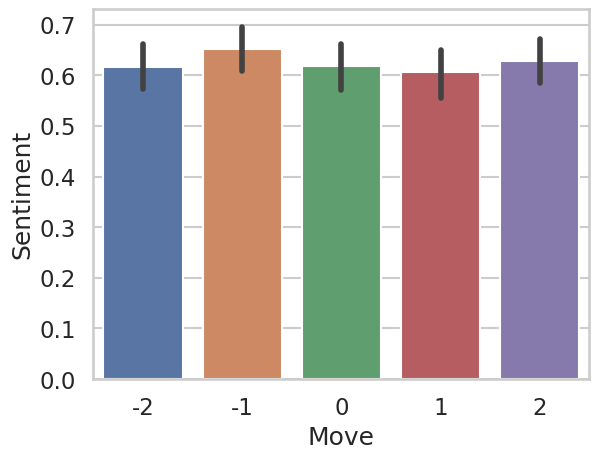

0.6988027438576884

Sentiment and 'Move' are possibly not correlated.


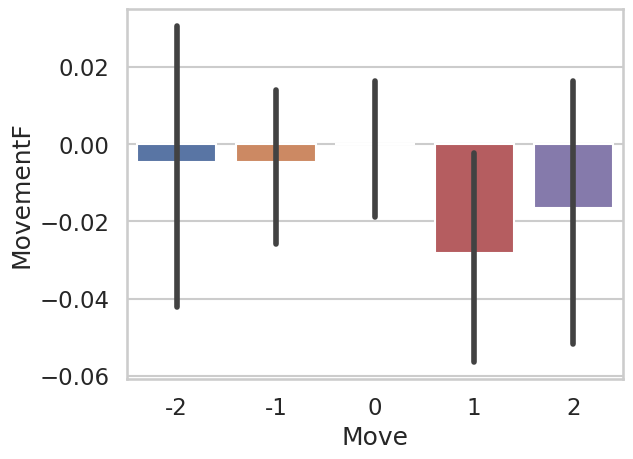

0.6257176770178501

MovementF and 'Move' are possibly not correlated.


In [506]:
# performing the one way ANOVA test
from scipy.stats import f_oneway
for col in data.columns:
    if col == 'Move':
        continue
    sns.barplot(data=data, x='Move', y=col)
    plt.show()
    catgroup = data.groupby('Move')[col].apply(list)
    p = f_oneway(*catgroup)[1]
    display(p)
    print (f"{col} and 'Move' are possibly",
            "correlated." if p<0.05 else "not correlated.")

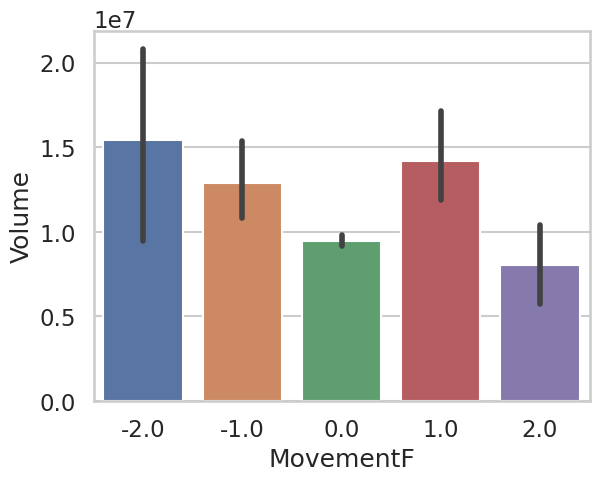

2.180674313327776e-06

Volume and 'MovementF' are possibly correlated.


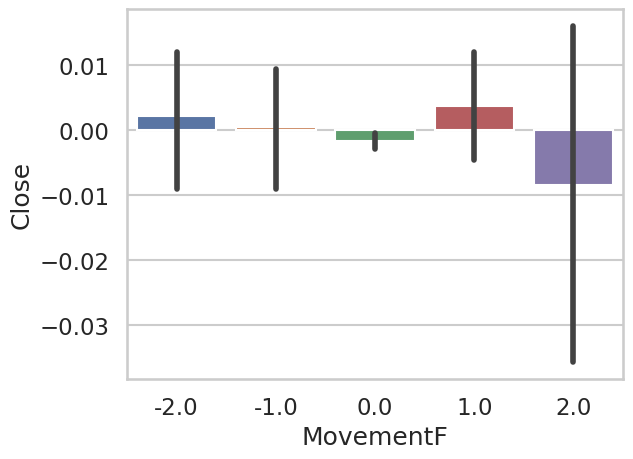

0.6294444400156674

Close and 'MovementF' are possibly not correlated.


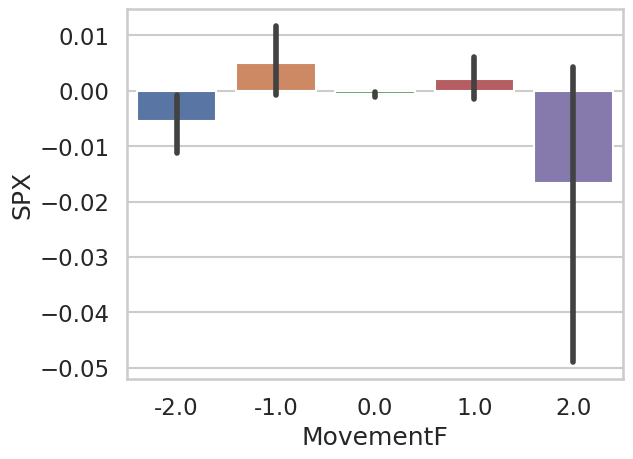

3.764709856069742e-06

SPX and 'MovementF' are possibly correlated.


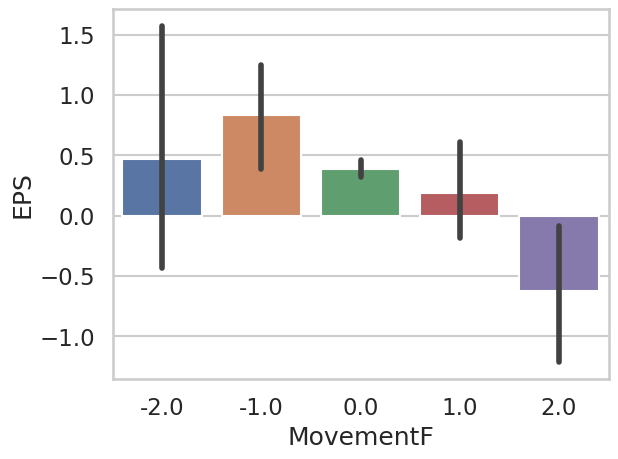

0.07984845095069341

EPS and 'MovementF' are possibly not correlated.


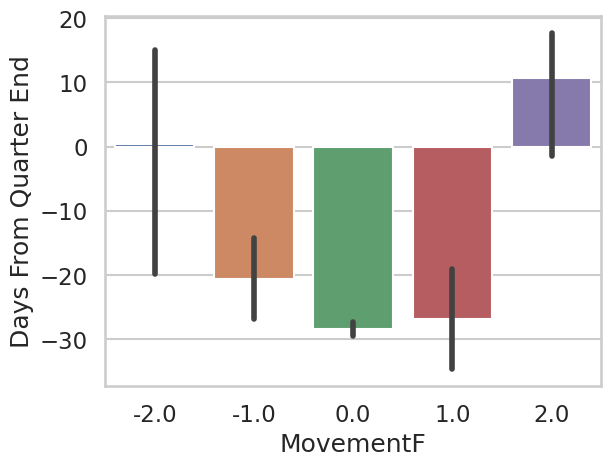

6.36766218734501e-06

Days From Quarter End and 'MovementF' are possibly correlated.


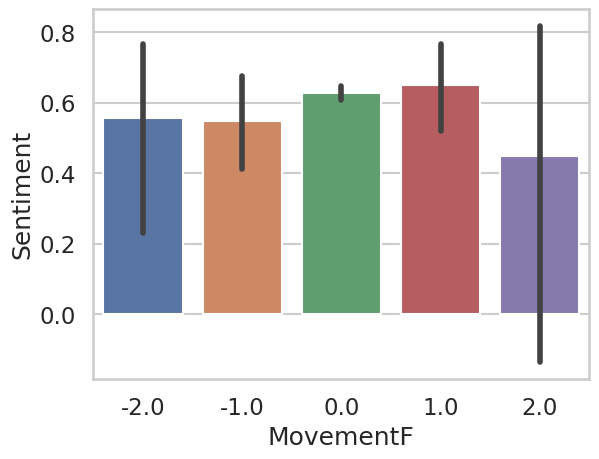

0.5489092967078509

Sentiment and 'MovementF' are possibly not correlated.


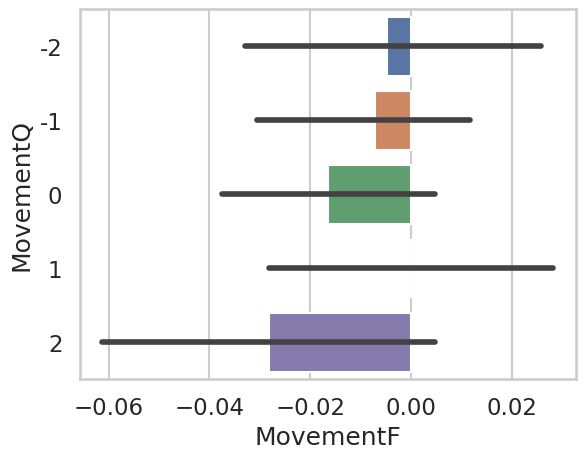

0.31942176247517934

MovementQ and 'MovementF' are possibly not correlated.


In [512]:
# performing the one way ANOVA test
from scipy.stats import f_oneway
for col in data.columns:
    if col == 'MovementF':
        continue
    sns.barplot(data=data, x='MovementF', y=col)
    plt.show()
    catgroup = data.groupby('MovementF')[col].apply(list)
    p = f_oneway(*catgroup)[1]
    display(p)
    print (f"{col} and 'MovementF' are possibly",
            "correlated." if p<0.05 else "not correlated.")

### Hypertuning the Discretization

The bins need to be values that won't overbalance the classes but will still reasonable correlation with the features that we have enough to be useful in the model.

 0    508
-1    503
 1    496
 2    314
-2    307
Name: Close, dtype: int64

Index(['Volume', 'Close', 'SPX', 'EPS', 'Days From Quarter End'], dtype='object')

Volume and 'Move' are possibly correlated.
Close_x and 'Move' are possibly not correlated.
SPX and 'Move' are possibly correlated.
EPS and 'Move' are possibly not correlated.
Days From Quarter End and 'Move' are possibly correlated.


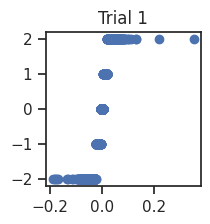

In [709]:
## Hypertuning the Discretization
def hypertune_bins(bins, tmp=df['Close'], data=data):
    """
    function to hypertune the discretization bins.
    receives bins, a list of 5 numbers that will act as the "cut-offs"
    and return the value counts and the one-Way F test results
    """
    def finstat_cut(df, bins):


        if df < bins[0]:
            bin = -2
        elif df< bins[1]:
            bin = -1
        elif df>bins[4]:
            bin = 2
        elif df>bins[3]:
            bin = 1
        else:
            bin = 0
        return bin

    tmp = tmp.copy()
    Move = tmp.apply(lambda x: finstat_cut(x, bins))
    plt.figure(figsize=(2,2))
    plt.scatter(tmp, Move)
    plt.title('Trial 1')
    display(Move.value_counts())


    dt = data.copy()
    dt = dt.drop(columns=['MovementQ', 'MovementF', 'Sentiment'])
    Move = Move.shift(1) # time shifting the target value by one day
    # all the features need to lag the PREDICTOR model
    # for this to be realistic
    display(dt.columns)
    dt = dt.merge(Move, left_index=True, right_index=True, how='outer').dropna()

    # performing the one way ANOVA test

    for col in dt.columns:
        if col == 'Close_y':
            continue
        catgroup = dt.groupby('Close_y')[col].apply(list)
        p = f_oneway(*catgroup)[1]

        print (f"{col} and 'Move' are possibly",
                "correlated." if p<0.05 else "not correlated.")


bins = [-0.025, -0.006, -0.000, 0.005, 0.02]
hypertune_bins(bins)

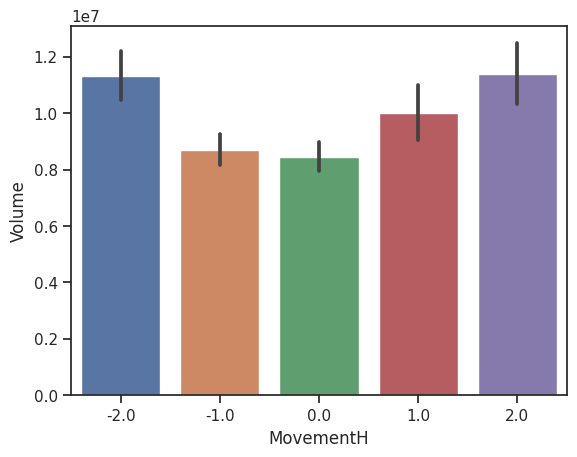

6.604287039191664e-09

Volume and 'MovementH' are possibly correlated.


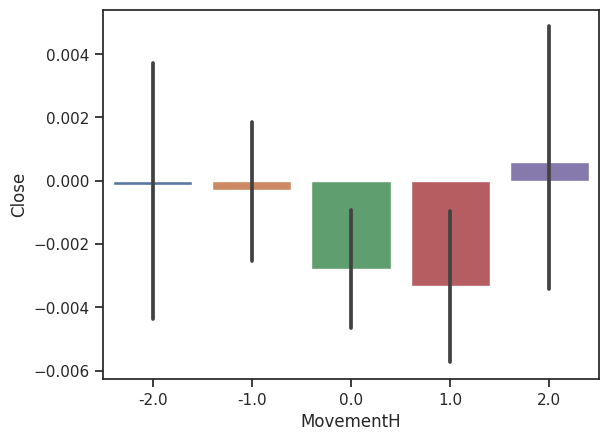

0.18028055410903424

Close and 'MovementH' are possibly not correlated.


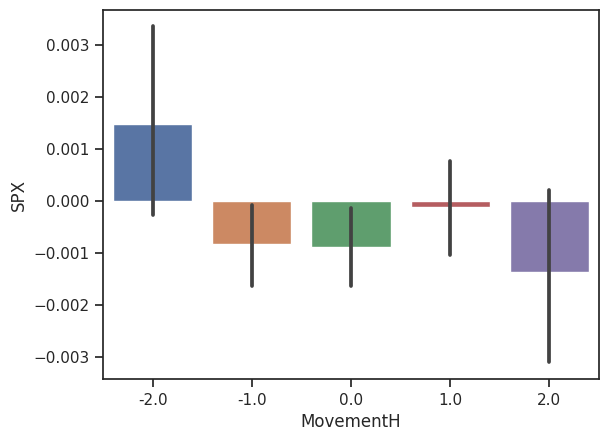

0.018913859696276788

SPX and 'MovementH' are possibly correlated.


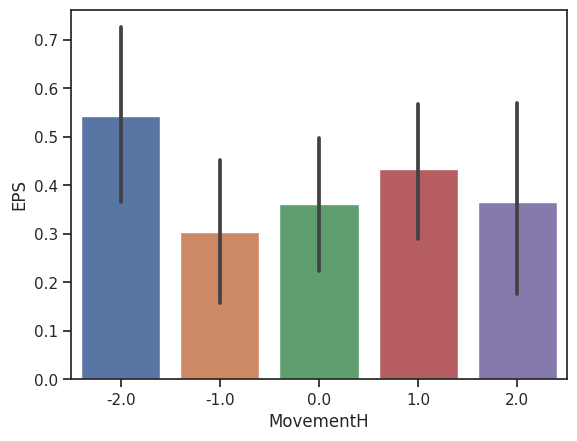

0.3273694360364228

EPS and 'MovementH' are possibly not correlated.


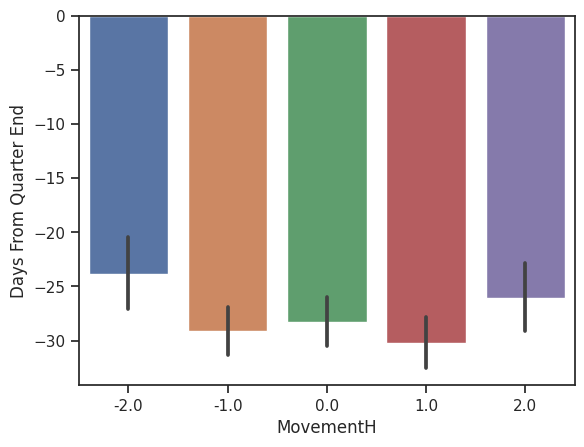

0.009004662452370318

Days From Quarter End and 'MovementH' are possibly correlated.


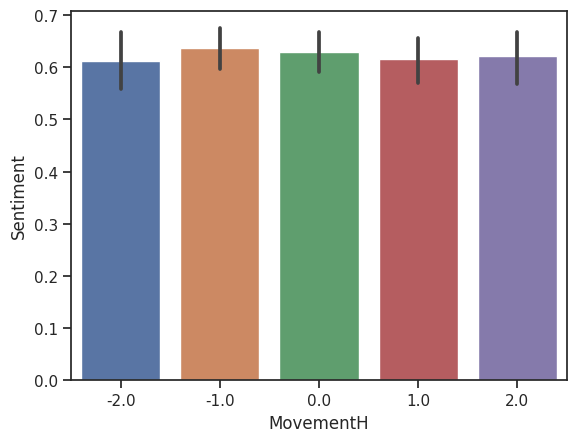

0.9431204299261781

Sentiment and 'MovementH' are possibly not correlated.


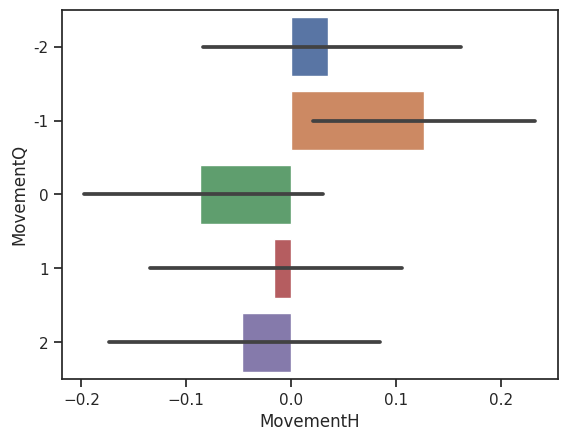

0.034501142170820995

MovementQ and 'MovementH' are possibly correlated.


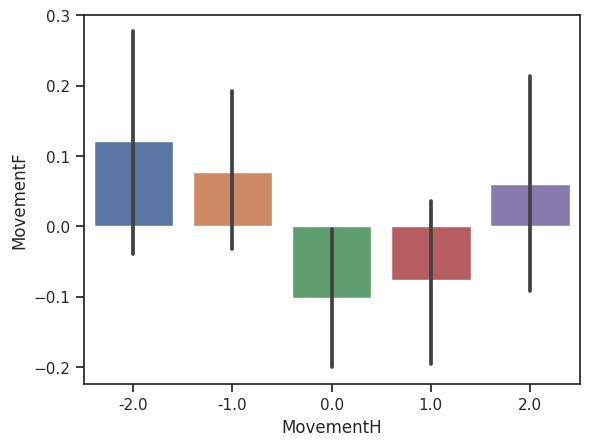

0.035474597180188576

MovementF and 'MovementH' are possibly correlated.


In [721]:
# performing the one way ANOVA test on the hypertuned bins
from scipy.stats import f_oneway
for col in data.columns:
    if col == 'MovementH':
        continue
    sns.barplot(data=data, x='MovementH', y=col)
    plt.show()
    catgroup = data.groupby('MovementH')[col].apply(list)
    p = f_oneway(*catgroup)[1]
    display(p)
    print (f"{col} and 'MovementH' are possibly",
            "correlated." if p<0.05 else "not correlated.")

## Sentiment Analysis: Drilling Deeper

So I can't quite let go of this. I want to test for sentiment analysis with time lag. 3-7 days. (Beyond that I feel is unrealistic for the volatility of the market). This will be approached like hypertuning.

In [551]:
sentiment_movement = data[['Sentiment', 'MovementF', 'MovementQ']].copy()
def tuning_the_sentiment_feature(shift, sentiment_movement=sentiment_movement):

    y = sentiment_movement['Sentiment'].shift(-shift) # time shifting the target value by one day
    tmp = sentiment_movement.drop(columns=['Sentiment']).merge(y, left_index=True, right_index=True, how='outer').dropna()
    print(f"Frame is now {len(tmp)} long from previous {len(sentiment_movement)}.")

    plt.figure(figsize=(3,3))
    sns.barplot(data=tmp, x='MovementF', y='Sentiment')

    plt.title(f"{shift} lag between MovementF and Sentiment")
    plt.show()
    catgroup = data.groupby('MovementF')['Sentiment'].apply(list)
    p = f_oneway(*catgroup)[1]
    display(p)
    print (f"{'Sentiment'} and 'MovementF' are possibly",
            "correlated." if p<0.05 else "not correlated.")

    plt.figure(figsize=(3,3))
    sns.barplot(data=tmp, x='MovementQ', y='Sentiment')
    plt.title(f"{shift} lag between MovementQ and Sentiment")
    plt.show()
    catgroup = data.groupby('MovementQ')['Sentiment'].apply(list)
    p = f_oneway(*catgroup)[1]
    display(p)
    print (f"After a shift of {shift} days, {'Sentiment'} and 'MovementQ' are possibly",
            "correlated." if p<0.05 else "not correlated.")



Frame is now 2124 long from previous 2127.


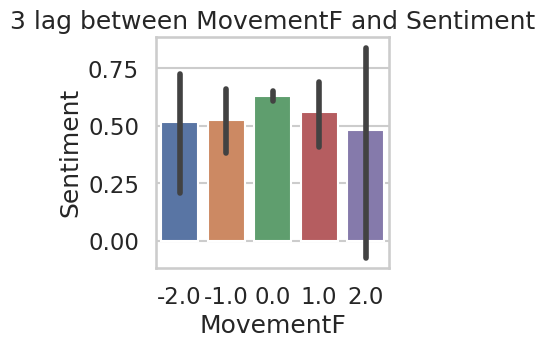

0.5489092967078509

Sentiment and 'MovementF' are possibly not correlated.


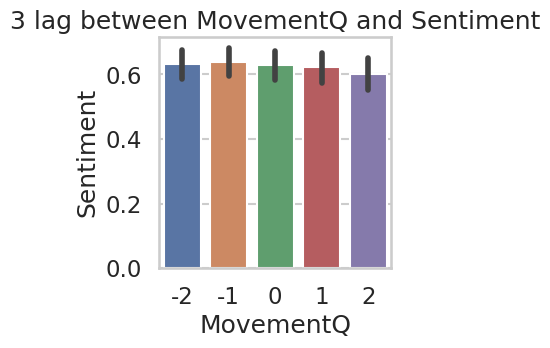

0.8499455650820478

After a shift of 3 days, Sentiment and 'MovementQ' are possibly not correlated.
Frame is now 2123 long from previous 2127.


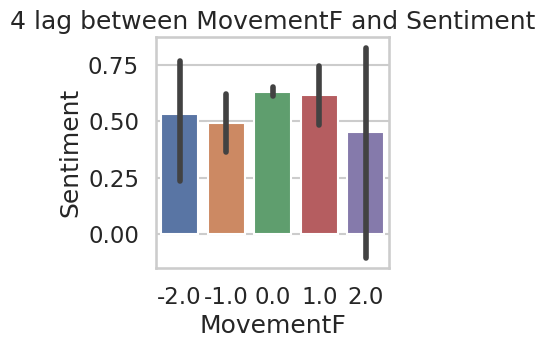

0.5489092967078509

Sentiment and 'MovementF' are possibly not correlated.


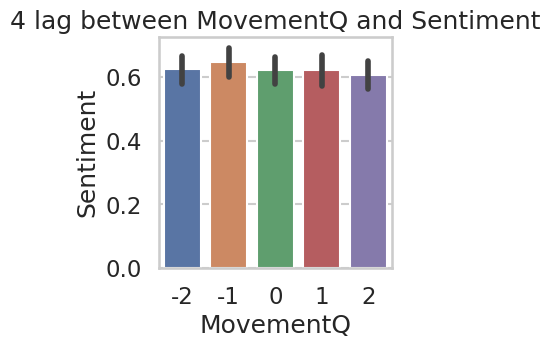

0.8499455650820478

After a shift of 4 days, Sentiment and 'MovementQ' are possibly not correlated.
Frame is now 2122 long from previous 2127.


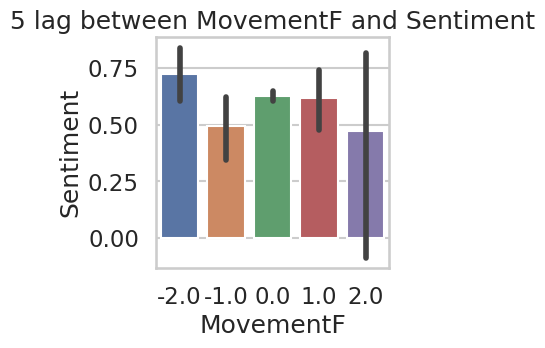

0.5489092967078509

Sentiment and 'MovementF' are possibly not correlated.


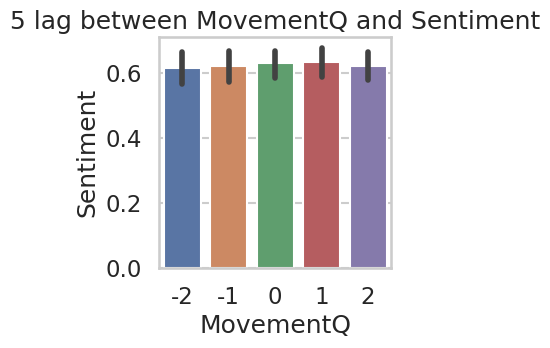

0.8499455650820478

After a shift of 5 days, Sentiment and 'MovementQ' are possibly not correlated.
Frame is now 2121 long from previous 2127.


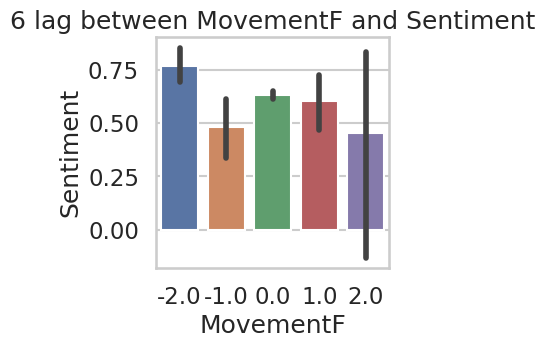

0.5489092967078509

Sentiment and 'MovementF' are possibly not correlated.


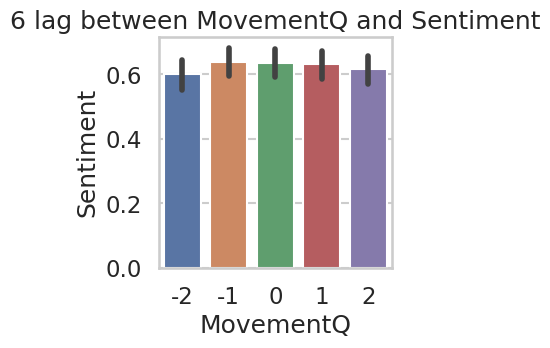

0.8499455650820478

After a shift of 6 days, Sentiment and 'MovementQ' are possibly not correlated.


In [552]:
for days in range(3,7):
    tuning_the_sentiment_feature(days)

**Conclusion:** I think we can definitely conclude that this sentiment dataset at least, has no correlation with the price movement.

# Time Series Preprocessing:
The features will not be useful. I will test the model with and without them to see if there's any impact but I suspect there won't be.

## Windowing the Dataset

To turn time series into supervised learning problem, use Pandas functionality for the **Sliding Windows** approach, making X (input columns) equal to the previous days's values and y, the target/output column is the predicted price.

In [523]:
def make_windows(tmp, window_size=3, horizon=1):
    """
    Input: 1-D time series Dataframe
    output: X 2D time series of window_size
    y: 1D time series lagged by horizon
    """
    data = tmp.copy()
    data = data.iloc[::-1]

    windows = list(data.rolling(window=window_size))[window_size:]
    window_data = pd.concat([pd.DataFrame(window.T.values) for window in windows])

    window_data.index = data.index[window_size:]

    return window_data[::-1]

In [722]:
windows = make_windows(data['Close'].to_frame())

In [723]:
windows = make_windows(data['Close'].to_frame())
model_df = data.merge(windows, right_index=True, left_index=True)

In [724]:
model_df.to_csv('/content/drive/MyDrive/stock_model/completed_model_dataframe.csv')

In [725]:
model_df

,Volume,Close,SPX,EPS,Days From Quarter End,Sentiment,MovementQ,MovementF,MovementH,0,1,2
Date,,,,,,,,,,,,
2023-06-15,7099915,0.029892,0.003672,4.00,-15,0.4610,2,2,NaN,-0.011773,-0.010003,0.029892
2023-06-14,8413089,-0.010003,-0.012178,4.00,-16,0.4610,-1,-1,2.0,-0.027738,-0.011773,-0.010003
2023-06-13,7820535,-0.011773,-0.000819,4.00,-17,0.4610,-1,-1,-1.0,-0.009404,-0.027738,-0.011773
2023-06-12,5967712,-0.027738,-0.006933,4.00,-18,0.5570,-2,-2,-1.0,-0.026016,-0.009404,-0.027738
2023-06-09,12372830,-0.009404,-0.009321,4.00,-21,0.5721,-1,-1,-2.0,-0.024014,-0.026016,-0.009404
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-13,18725580,-0.001297,0.005813,-0.13,13,0.7395,0,0,0.0,0.031675,-0.015587,-0.001297
2015-01-12,12940624,-0.015587,0.002579,-0.13,12,0.7395,-1,-1,0.0,0.015488,0.031675,-0.015587
2015-01-09,9574337,0.031675,0.008094,-0.13,9,0.7395,2,2,-1.0,-0.022251,0.015488,0.031675


Thus ends the relatively vigorous feature engineering. The next notebook will build our model in stages, then tune those hyperparamneters. See you then!